In [1]:
import os
import pandas as pd
import numpy as np
from eval_functions import *

project_name = "ANT"
train_data, test_data = get_datasets(project_name)
save_dir = os.path.join('./explainer/',project_name)

X_train, X_test, y_train, y_test = get_train_test(project_name)

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Train and save model
global_model= train_global_model(project_name,'SVM', X_train, y_train) #Model object
global_model_LR = train_global_model(project_name,'LR', X_train, y_train)
global_model_BRCG = train_global_model(project_name,'BRCG', X_train, y_train)
global_model_LRR = train_global_model(project_name,'LogRR', X_train, y_train)

Learning CNF rule with complexity parameters lambda0=0.001, lambda1=0.001
Initial LP solved
Iteration: 1, Objective: 0.2058
Iteration: 2, Objective: 0.1862
Iteration: 3, Objective: 0.1702
Iteration: 4, Objective: 0.1566
Iteration: 5, Objective: 0.1406
Iteration: 6, Objective: 0.1340
Iteration: 7, Objective: 0.1326
Iteration: 8, Objective: 0.1308
Iteration: 9, Objective: 0.1159
Iteration: 10, Objective: 0.1094
Iteration: 11, Objective: 0.1076
Iteration: 12, Objective: 0.1068
Iteration: 13, Objective: 0.1068
Iteration: 14, Objective: 0.1065
Iteration: 15, Objective: 0.1055
Iteration: 16, Objective: 0.1051
Iteration: 17, Objective: 0.1050
Iteration: 18, Objective: 0.1047
Iteration: 19, Objective: 0.1047


In [3]:

pred_SVM, defect_prob_SVM = global_model.predict()
pred_LR, defect_prob_LR = global_model_LR.predict()
pred_BRCG, defect_prob_BRCG = global_model_BRCG.predict()
pred_LRR, defect_prob_LRR = global_model_LRR.predict()


cnf


In [ ]:
#Evaluate model performance
global_model.evaluate_performance()
global_model_LR.evaluate_performance()
global_model_BRCG.evaluate_performance()
global_model_LRR.evaluate_performance()

In [ ]:
feat = global_model_LRR.X_train
std_feat = global_model_LRR.X_trainStd
# print(std_feat)

In [ ]:
print(global_model_LR.X_train)

In [10]:
# BR explaination
exp_BRCG = global_model_BRCG.model.explain(maxConj=5)
print(len(exp_BRCG['rules']))
print(exp_BRCG)

5
{'isCNF': True, 'rules': ['loc <= 23.70', 'wmc > 5.00 AND loc <= 169.00', 'mfa <= 0.00 AND cam > 0.50', 'lcom > 4.00 AND dam <= 0.00', 'dit > 1.00 AND ce <= 7.00 AND loc <= 355.40']}


In [8]:
exp_LRR = global_model_LRR.model.explain()
exp_LRRh = global_model_LRR.model.explain(highDegOnly=True)
# print(exp_LRRh)
# Separate 1st-degree rules into (feature, operation, value) to count unique features
dfx2 = exp_LRR['rule/numerical feature']
highOrd = exp_LRRh['rule']
dfx2 = dfx2[~dfx2.isin(highOrd)].str.split(' ', expand=True)
dfx2.columns = ['feature','operation','value']
dfx2['feature'].nunique() # includes intercept
uniq = dfx2['feature'].unique()

({'dit': <Figure size 432x288 with 1 Axes>},
 dit    2.899135
 dtype: float64)

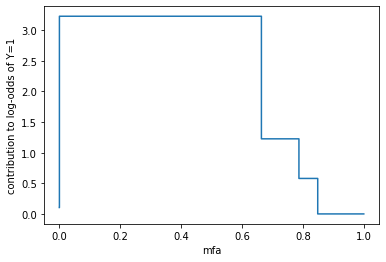

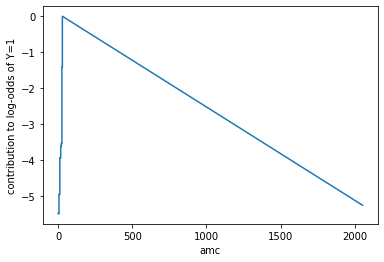

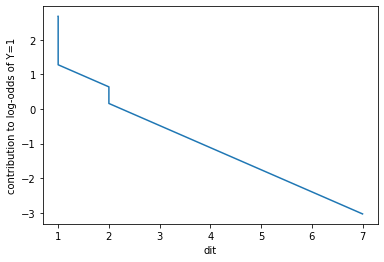

In [9]:
data = pd.concat([train_data,test_data])
global_model_LRR.model.visualize(data,global_model_LRR.fb,['mfa'])
global_model_LRR.model.visualize(data,global_model_LRR.fb,['amc'])
global_model_LRR.model.visualize(data,global_model_LRR.fb,['dit'])

In [12]:
standardised = global_model_LRR.X_trainStd
binarised = global_model_LRR.X_train
print(binarised.head(n=5))

feature         wmc                                                    \
operation        <=                                                     
value     2.700000  4.000000  5.000000  7.000000  9.000000  11.200000   
0                 0         1         1         1         1         1   
1                 0         1         1         1         1         1   
2                 0         0         0         0         0         1   
3                 0         0         0         0         0         0   
4                 0         0         0         0         0         0   

feature                                            ...    avg_cc            \
operation                                       >  ...        <=         >   
value     16.000000 20.000000 30.000000 2.700000   ... 2.576440  0.666700    
0                 1         1         1         1  ...         1         0   
1                 1         1         1         1  ...         1         1   
2                 1      

In [ ]:
pred_df = X_test.copy()
pred_df['pred'] = pred
pred_df['defect'] = y_test
pred_df['defect_prob'] = defect_prob

correctly_predicted_df = pred_df[(pred_df['pred']==1) & (pred_df['defect']==1)]
feature_df = correctly_predicted_df.loc[:,correctly_predicted_df.columns[: -3]]



In [ ]:
import pickle
from pyexplainer.pyexplainer_pyexplainer import *
from lime.lime.lime_tabular import LimeTabularExplainer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

explanations = [] #list of explanations
features = X_test.columns
dep = 'defect'
class_label = ['clean','defect']
test_label = y_test.loc[correctly_predicted_df.index]

pyExp = PyExplainer(X_train, y_train, features, dep, global_model, class_label)
limeExp = LimeTabularExplainer(X_train.values, 
                                      feature_names=features, class_names=class_label, 
                                      random_state=0)
results = pd.DataFrame()

# generate explanation for each data row
for i in range(0,len(feature_df)):
# for i in range(0,3):
    X_explain = feature_df.iloc[[i]] #that data row
    y_explain = test_label.iloc[[i]]
    row_index = str(X_explain.index[0]) #name of instance

    pyExplanation = pyExp.explain(X_explain,
                                   y_explain,
                                   search_function = 'CrossoverInterpolation')


    pyExplanation['name'] = row_index
    pyExplanation['local_model'] = pyExplanation['local_rulefit_model']
    del pyExplanation['local_rulefit_model']
    # X_explain = feature_df.iloc[i]
    exp, synt_inst, synt_inst_for_local_model, selected_feature_indices, local_model = limeExp.explain_instance(feature_df.iloc[i], global_model.predict_proba, num_samples=2110)
    
    limeExplanation = {}
    limeExplanation['rule'] = exp
    limeExplanation['synthetic_instance_for_global_model'] = synt_inst
    limeExplanation['synthetic_instance_for_local_model'] = synt_inst_for_local_model #10 most important features binary rep
    limeExplanation['local_model'] = local_model
    limeExplanation['selected_feature_indices'] = selected_feature_indices #10 most important feature indexes
    limeExplanation['name'] = row_index
 
    all_explainer = {'pyExplainer':pyExplanation, 'LIME': limeExplanation}
    explanations.append(all_explainer)

    #calculate euclidean distance between X_explain and synthetic data
    py_euc = euclidean_distances(X_explain.values,pyExplanation['synthetic_data'].values)
    lime_euc = euclidean_distances(X_explain.values,limeExplanation['synthetic_instance_for_global_model'])
    #calculate median 
    py_euc_med = np.median(py_euc)
    lime_euc_med = np.median(lime_euc)

    pyExp_series = pd.Series(data=[project_name,row_index,'pyExplainer',py_euc_med])
    limeExp_series = pd.Series(data=[project_name,row_index,'LIME',lime_euc_med])
    results = results.append(pyExp_series, ignore_index=True)
    results = results.append(limeExp_series, ignore_index=True)

    # print(py_euc_med)
    # print(lime_euc_med)
    # print(X_explain.values)

results.columns = ['project','name', 'method', 'euc_dist_med']
results.to_csv('./eval_results/'+'rq1_'+ project_name+'_'+'SVM'+'.csv',index=False)
pickle.dump(explanations,open(save_dir + '/SVM' +'/explainers_'+row_index+'.pkl','wb'))

RQ1: Similarity of synthetic neighbours to instance being explained

In [ ]:
rq1_results()

RQ2: Accuracy of local model

In [ ]:
#true labels and predictions for score calculation
explanations = pickle.load(open(os.path.join(save_dir,'explainers_'+row_index+'.pkl'),'rb'))
pyexp_label, pyexp_prob = [],[]
lime_label, lime_prob = [],[]
rq2_results = pd.DataFrame()
# for each datarow, get explanation objs and evaluate local model accuracy
for i in range(0,len(feature_df)):
# for i in range(0,3):
    X_explain = feature_df.iloc[[i]]
    row_index = str(X_explain.index[0])
    pyExplanation = explanations[i]['pyExplainer']
    limeExplanation = explanations[i]['LIME']

    pyExp_synthetic_data = pyExplanation['synthetic_data'].values 
    limeExp_synthetic_data = limeExplanation['synthetic_instance_for_global_model']
    limeExp_synthetic_data_local = limeExplanation['synthetic_instance_for_local_model']

    pyExp_local_model = pyExplanation['local_model']
    limeExp_local_model = limeExplanation['local_model']

    pyExp_global_pred = global_model.predict(pyExp_synthetic_data)
    pyExp_local_prob = pyExp_local_model.predict_proba(pyExp_synthetic_data)[:,1] #probability of being in class 1
    pyExp_local_pred = pyExp_local_model.predict(pyExp_synthetic_data)

    limeExp_global_pred = global_model.predict(limeExp_synthetic_data)
    limeExp_local_prob = limeExp_local_model.predict(limeExp_synthetic_data_local)
    limeExp_local_pred = np.round(limeExp_local_prob)

    pyexp_label.extend(list(pyExp_global_pred))
    pyexp_prob.extend(list(pyExp_local_prob))
    
    lime_label.extend(list(limeExp_global_pred))
    lime_prob.extend(list(limeExp_local_prob))

    pyExp_auc = metrics.roc_auc_score(pyExp_global_pred,pyExp_local_prob)
    pyExp_f1 = metrics.f1_score(pyExp_global_pred, pyExp_local_pred)
    
    lime_auc = metrics.roc_auc_score(limeExp_global_pred, limeExp_local_prob)
    lime_f1 = metrics.f1_score(limeExp_global_pred, limeExp_local_pred)

    pyExp_series = pd.Series(data=[project_name,row_index,'pyExplainer',pyExp_auc,pyExp_f1])
    limeExp_series = pd.Series(data=[project_name,row_index,'LIME',lime_auc,lime_f1])

    rq2_results = rq2_results.append(pyExp_series,ignore_index=True)
    rq2_results = rq2_results.append(limeExp_series,ignore_index=True)

rq2_results.columns = ['project','name','method','AUC','F1']
rq2_results.to_csv('./eval_results/'+'rq2_'+project_name+'_'+'SVM'+'_global_vs_local_synt_pred.csv',index=False)

pred_df= pd.DataFrame()
pred_df['technique'] = ['pyExplainer']*len(pyexp_label) + ['LIME']*len(lime_label)
pred_df['label'] = pyexp_label+lime_label
pred_df['prob'] = pyexp_prob+lime_prob
pred_df['project'] = project_name

pred_df.to_csv('./eval_results/'+'rq2_'+project_name+'_'+'SVM'+'_probability_distribution.csv',index=False)

In [ ]:
rq2_result()

RQ2: Probability Distribution

In [ ]:
from eval_functions import *
rq2_probability_distribution()

RQ3: Uniqueness of Explanations

In [ ]:
def eval_rule(rule, x_df):
    """Returns list of boolean values that reflects if feature values in x_df matches the rule"""
    var_in_rule = list(set(re.findall('[a-zA-Z_]+', rule))) #list of features in the rule
    
    rule = re.sub(r'\b=\b','==',rule)
    if 'or' in var_in_rule:
        var_in_rule.remove('or')
        
    rule = rule.replace('&','and')
    eval_result_list = []

    # print(var_in_rule)
    # print('-----------------------------------')
    for i in range(0,len(x_df)):
        x = x_df.iloc[[i]]
        col = x.columns
        var_dict = {}

        for var in var_in_rule:
            # print(var)
            # print(float(x[var]))
            var_dict[var] = float(x[var])
            # print(var_dict[var])
        
        eval_result = eval(rule,var_dict)
        eval_result_list.append(eval_result)

        
    return eval_result_list
    
def get_rule_str_of_rulefit(local_model, X_explain):
    rules = local_model.get_rules()
    rules = rules[(rules['type']=='rule') & (rules['coef'] > 0) & (rules['importance'] > 0)]
    rules_list = list(rules['rule'])
    
    rule_eval_result = []
    
    for r in rules_list:
        py_exp_pred = eval_rule(r, X_explain)[0]
        rule_eval_result.append(py_exp_pred)
          
    rules['is_satisfy_instance'] = rule_eval_result

    rules = rules[rules['is_satisfy_instance']==True]

    rules = rules.sort_values(by='importance', ascending=False)
    
    rule_str = rules.iloc[0]['rule'] #most important rule that is satisfied by instance
    
    return rule_str

In [ ]:
# explanations = pickle.load(open(os.path.join(save_dir,'explainers_'+row_index+'.pkl'),'rb'))
rq3_result = pd.DataFrame()
for i in range(0,len(feature_df)):
# for i in range(0,3):
    X_explain = feature_df.iloc[[i]]
    row_index = str(X_explain.index[0])
    pyExplanation = explanations[i]['pyExplainer']
    limeExplanation = explanations[i]['LIME']

    pyExp_local_model = pyExplanation['local_model']
    limeExp_local_model = limeExplanation['local_model']
    
    
    # generate explanations 
    py_exp_the_best_defective_rule_str = get_rule_str_of_rulefit(pyExp_local_model, X_explain)
    lime_the_best_defective_rule_str = limeExplanation['rule'].as_list()[0][0]

    # pyexp - eval rule(condition) for each condition in rule string
    condition_list = py_exp_the_best_defective_rule_str.split('&')

    for cond in condition_list:
        cond = cond.strip()
        pyExp_rule_eval = eval_rule(cond, X_test)
        pyExp_rule_eval = np.array(pyExp_rule_eval).astype(bool)

        rule_recall = metrics.recall_score(y_test,pyExp_rule_eval) #% of actual positives predicted correctly

        pyExp_series_test = pd.Series(data=[project_name,row_index,'pyExplainer','SVM', cond, rule_recall])
        rq3_result = rq3_result.append(pyExp_series_test,ignore_index=True)

    lime_rule_eval = eval_rule(lime_the_best_defective_rule_str,X_test)
    lime_rule_eval = np.array(lime_rule_eval).astype(bool)
    rule_recall = metrics.recall_score(y_test,lime_rule_eval)

    lime_series_test = pd.Series(data=[project_name,row_index,'LIME','SVM', lime_the_best_defective_rule_str, rule_recall])
    rq3_result = rq3_result.append(lime_series_test,ignore_index=True)

rq3_result.columns = ['project','commit_id','method','global_model','explanation','recall']
rq3_result.to_csv('./eval_results/'+'rq3_'+ project_name+'_'+'SVM'+'_eval_rulesplit_recall.csv', index=False)


# print(rq3_result)
    # print(py_exp_the_best_defective_rule_str)
    # print(lime_the_best_defective_rule_str)


In [ ]:
rq3_results()

In [ ]:
# pyexp1 = explanations[0]['pyExplainer']
# limeExp1 = explanations[0]['LIME']
# print(pyexp1['X_explain'].values)
# print(limeExp1['synthetic_instance_for_global_model'].shape)
# print(limeExp1['synthetic_instance_for_local_model'].shape)
# print(pyexp1['synthetic_data'].shape)
# print(limeExp1['selected_feature_indices'])
# print(limeExp1['synthetic_instance_for_global_model'][1])
# print(limeExp1['synthetic_instance_for_global_model'][2])
# print(limeExp1['synthetic_instance_for_global_model'][1])
# print(limeExp1['synthetic_instance_for_local_model'][1])
# print(limeExp1['synthetic_instance_for_local_model'])
# print(pyexp1['synthetic_data'].values[0])



In [ ]:
# pyexp1['synthetic_data'].values[2]
# print(pyexp1['synthetic_data'].iloc[[2]])


In [ ]:
# print(limeExp1['synthetic_instance_for_global_model'][0])
